pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Embed into Latent Space

In [1]:
from generation.evolution import ModifiedHaltingEvolution
from scipy import ndimage
import random
from NovelSwarmBehavior.novel_swarms.behavior.AngularMomentum import AngularMomentumBehavior
from NovelSwarmBehavior.novel_swarms.behavior.AverageSpeed import AverageSpeedBehavior
from NovelSwarmBehavior.novel_swarms.behavior.GroupRotationBehavior import GroupRotationBehavior
from NovelSwarmBehavior.novel_swarms.behavior.RadialVariance import RadialVarianceBehavior
from NovelSwarmBehavior.novel_swarms.behavior.ScatterBehavior import ScatterBehavior
from NovelSwarmBehavior.novel_swarms.behavior.SensorOffset import GeneElementDifference
from NovelSwarmBehavior.novel_swarms.config.AgentConfig import DiffDriveAgentConfig
from NovelSwarmBehavior.novel_swarms.config.EvolutionaryConfig import GeneticEvolutionConfig
from NovelSwarmBehavior.novel_swarms.config.OutputTensorConfig import OutputTensorConfig
from NovelSwarmBehavior.novel_swarms.config.WorldConfig import RectangularWorldConfig
from NovelSwarmBehavior.novel_swarms.novelty.GeneRule import GeneRule
from NovelSwarmBehavior.novel_swarms.sensors.GenomeDependentSensor import GenomeBinarySensor
from NovelSwarmBehavior.novel_swarms.sensors.SensorSet import SensorSet
from generation.evolution import ModifiedHaltingEvolution, ModifiedNoveltyArchieve
from generation.halted_evolution import HaltedEvolution
from data.swarmset import SwarmDataset, DataBuilder
import numpy as np
import pygame

def evolution_controller():
    sensors = SensorSet([
        GenomeBinarySensor(genome_id=8, draw=False),
        GenomeBinarySensor(genome_id=9, draw=False)
    ])

    agent_config = DiffDriveAgentConfig(
        sensors=sensors,
        seed=None,
    )

    genotype = [
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=((1/3) * np.pi), _min=-((2/3) * np.pi), mutation_step=(np.pi/2), round_digits=4),
        GeneRule(_max=((2/3) * np.pi), _min=-((1/3) * np.pi), mutation_step=(np.pi/2), round_digits=4),
    ]

    phenotype = [
        AverageSpeedBehavior(),
        AngularMomentumBehavior(),
        RadialVarianceBehavior(),
        ScatterBehavior(),
        GroupRotationBehavior(),
        # GeneElementDifference(8, 9)
    ]

    world_config = RectangularWorldConfig(
        size=(500, 500),
        n_agents=24,
        seed=None,
        behavior=phenotype,
        agentConfig=agent_config,
        padding=15
    )

    novelty_config = GeneticEvolutionConfig(
        gene_rules=genotype,
        phenotype_config=phenotype,
        n_generations=50,
        n_population=100,
        crossover_rate=0.7,
        mutation_rate=0.15,
        world_config=world_config,
        k_nn=15,
        simulation_lifespan=2500,
        display_novelty=True,
        save_archive=True,
        show_gui=True,
    )

    pygame.init()
    pygame.display.set_caption("Evolutionary Novelty Search")
    screen = pygame.display.set_mode((world_config.w, world_config.h))

    output_config = OutputTensorConfig(
        timeless=True,
        total_frames=80,
        steps_between_frames=2,
        screen=screen
    )

    halted_evolution = ModifiedHaltingEvolution(
        world=world_config,
        evolution_config=novelty_config,
        output_config=output_config
    )

    return halted_evolution, screen

def build_random_dataset():
    halted_evolution, screen = evolution_controller()
    baseline_data = DataBuilder("data/full-dual-sensors", steps=1200, agents=30, ev=halted_evolution, screen=screen)
    baseline_data.create()
    baseline_data.evolution.close()

def pretraining(data, ensemble, data_cutoff=None, data_size=500):
    if data_cutoff is None:
        data_cutoff = len(data) - 1
    samples = np.random.random_integers(0, data_cutoff, (data_size, 2))
    total_loss = np.array([0.0 for i in range(len(ensemble.ensemble))])
    total_updates = 0
    for i, s in enumerate(samples):
        if i % (data_size // 20) == 0:
            print(f"Unsupervised Training.. {(i * 100) / data_size}")
        anchor_image = data[s[0]][0]
        pos_image = data[s[0]][0]

        pos_images = np.stack([
            [ndimage.rotate(pos_image, 90)],
            [ndimage.rotate(pos_image, 180)],
            [ndimage.rotate(pos_image, 270)],
            # [ndimage.gaussian_filter(pos_image, 1)],
            # [ndimage.gaussian_filter(pos_image, 3)],
            # [ndimage.gaussian_filter(pos_image, 5)],
        ])

        anchor_images = np.stack([[anchor_image] for _ in pos_images])
        neg_images = np.stack([[data[random.randint(0, data_cutoff)][0]] for _ in pos_images])
        losses = ensemble.train_batch(anchor_images, pos_images, neg_images)
        total_loss += np.array(losses)
        total_updates += 1

    return total_loss / total_updates

def train(ensemble, anchor_img, pos_img, neg_img):
    pos_images = np.stack([
        [ndimage.rotate(pos_img, 90)],
        [ndimage.rotate(pos_img, 180)],
        [ndimage.rotate(pos_img, 270)],
    ])

    anchor_images = np.stack([[anchor_img] for _ in pos_images])
    neg_images = np.stack([[neg_img] for _ in pos_images])
    losses = ensemble.train_batch(anchor_images, pos_images, neg_images)
    return np.array(losses)

def evaluate(ensemble, anchor_img, pos_img, neg_img):
    loss = ensemble.eval_triplet(anchor_img, pos_img, neg_img)
    return loss

def human_in_the_loop(anchor_dataset, network, optimizer, loss_fn, HIL_archive, random_archive, stop_at):
    print("HIL TIME!")
    improvements, human_loss, triplet_helpfulness, embedded_archive = hil.humanInput(anchor_dataset, network, optimizer, loss_fn, HIL_archive, random_archive, stop_at)
    print(f"Improvement Count: {improvements}, loss: {human_loss}")

    HIL_archive.save_to_file(f"data/queries/{trial_name}_hil.csv")
    random_archive.save_to_file(f"data/queries/{trial_name}_rand.csv")
    return improvements, human_loss, triplet_helpfulness, embedded_archive

pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Pretraining

In [8]:
# Save Model
import torch
import time
from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble

PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = Ensemble(size=5, output_size=5, lr=30e-6, learning_decay=0.9, decay_step=200)
ensemble.load_ensemble("Nov21-subzerofive")
sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)

t_1 = time.time()
if PRETRAINING:
    epochs = 0
    while loss > target:
        loss = pretraining(sampled_dataset, ensemble, data_cutoff=None, data_size=100)
        print(f"Epoch {epochs}, loss: {loss}, val: {sum(loss) / len(loss)}")
        epochs += 1
        ensemble.step_schedulers()
        loss = sum(loss) / len(loss)

print(f"Total Pre-training Time: {time.time() - t_1}")
ensemble.save_ensemble(f"{int(time.time())}")

/tmp/ipykernel_3507367/2389041412.py:108: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Unsupervised Training.. 5.0
Unsupervised Training.. 10.0
Unsupervised Training.. 15.0
Unsupervised Training.. 20.0
Unsupervised Training.. 25.0
Unsupervised Training.. 30.0
Unsupervised Training.. 35.0
Unsupervised Training.. 40.0
Unsupervised Training.. 45.0
Unsupervised Training.. 50.0
Unsupervised Training.. 55.0
Unsupervised Training.. 60.0
Unsupervised Training.. 65.0
Unsupervised Training.. 70.0
Unsupervised Training.. 75.0
Unsupervised Training.. 80.0
Unsupervised Training.. 85.0
Unsupervised Training.. 90.0
Unsupervised Training.. 95.0
Epoch 0, loss: [0.         0.09045743 0.         0.04963419 0.        ], val: 0.02801832318305969
Unsupervised Training.. 0.0
Unsupervised Training.. 5.0
Unsupervised Training.. 10.0
Unsupervised Training.. 15.0
Unsupervised Training.. 20.0
Unsupervised Training.. 25.0
Unsupervised Training.. 30.0
Unsupervised Training.. 35.0
Unsupervised Training.. 40.0
Unsupervised Training.. 45.0
Unsupervised Training.. 50.0
Unsuper

KeyboardInterrupt: 

In [5]:
ensemble.save_ensemble(f"{int(time.time())}")

In [25]:
# Analyze and Sample from the ensamble
import torch
import time
import os
from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from NovelSwarmBehavior.novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from networks.ensemble import Ensemble
from matplotlib import pyplot as plot
from data.swarmset import ContinuingDataset, SwarmDataset

ensemble = Ensemble(size=5, output_size=5, lr=5e-4, learning_decay=0.8, decay_step=4)
ensemble.load_ensemble("surgery_ensemble")
sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
parent_folder = "/home/connor/Desktop/SwarmsResults/AugmentedTests/Encoder_plus_original_bvec_Nov_7"
sub_folder = "data"
retrieved_data = ContinuingDataset(directory=parent_folder, create=False, folder_name=sub_folder)
retrieved_data = sampled_dataset

archive = NoveltyArchive(
    pheno_file=os.path.join("/home/connor/Desktop/SwarmsResults/AugmentedTests/Encoder_plus_original_bvec_Nov_7/behaviors", "1667764573_b__1667801491.csv"),
    geno_file=os.path.join("/home/connor/Desktop/SwarmsResults/AugmentedTests/Encoder_plus_original_bvec_Nov_7/controllers", "1667764573_g__1667801491.csv"),
    absolute=True
)

TRIALS = 1000
rand_samp = [
    (random.randrange(0, len(retrieved_data)), random.randrange(0, len(retrieved_data)), random.randrange(0, len(retrieved_data))) for i in range(TRIALS)
]
print("Samples Collected")

entropy = []
for i in range(TRIALS):
    # h = ensemble.entropy_agreement(retrieved_data[rand_samp[i][0]][0], positive=None, negative=retrieved_data[rand_samp[i][2]][0])
    h = ensemble.entropy_agreement(retrieved_data[rand_samp[i][0]][0], positive=retrieved_data[rand_samp[i][1]][0], negative=retrieved_data[rand_samp[i][2]][0])
    print(h)
    entropy.append(h)
print("Entropy Calculated")

agreement = [0, 0]
for i in range(TRIALS):
    # agree = ensemble.binary_agreement(retrieved_data[rand_samp[i][0]][0], positive=None,negative=retrieved_data[rand_samp[i][2]][0])
    agree = ensemble.binary_agreement(retrieved_data[rand_samp[i][0]][0], positive=retrieved_data[rand_samp[i][1]][0],negative=retrieved_data[rand_samp[i][2]][0])
    if agree:
        agreement[1] += 1
        continue
    agreement[0] += 1
print("Aggreement Calculated")

Samples Collected
tensor(0.6931)
tensor(1.0081)
tensor(0.0437)
tensor(0.6931)
tensor(0.6932)
tensor(1.0053)
tensor(1.9073e-05)
tensor(0.6931)
tensor(0.6931)
tensor(0.0274)
tensor(1.6094)
tensor(0.5651)
tensor(0.0168)
tensor(4.4343e-05)
tensor(1.6094)
tensor(1.3213)
tensor(0.6931)
tensor(0.6931)
tensor(0.)
tensor(0.0001)
tensor(0.2228)
tensor(0.6931)
tensor(1.6094)
tensor(1.6094)
tensor(0.6931)
tensor(0.8682)
tensor(0.6931)
tensor(0.6931)
tensor(0.8011)
tensor(1.6094)
tensor(0.7899)
tensor(0.6931)
tensor(0.6931)
tensor(0.6931)
tensor(0.6931)
tensor(1.6094)
tensor(0.0004)
tensor(0.6931)
tensor(0.0153)
tensor(0.)
tensor(1.6094)
tensor(0.0025)
tensor(0.1533)
tensor(0.6931)
tensor(0.6931)
tensor(0.0187)
tensor(0.6931)
tensor(0.6931)
tensor(0.7615)
tensor(0.0153)
tensor(0.6932)
tensor(0.6931)
tensor(0.6931)
tensor(0.6931)
tensor(0.0251)
tensor(1.3344)
tensor(0.6931)
tensor(0.6931)
tensor(6.6757e-06)
tensor(0.)
tensor(0.6931)
tensor(1.6094)
tensor(1.6094)
tensor(0.6931)
tensor(0.6931)
tensor(

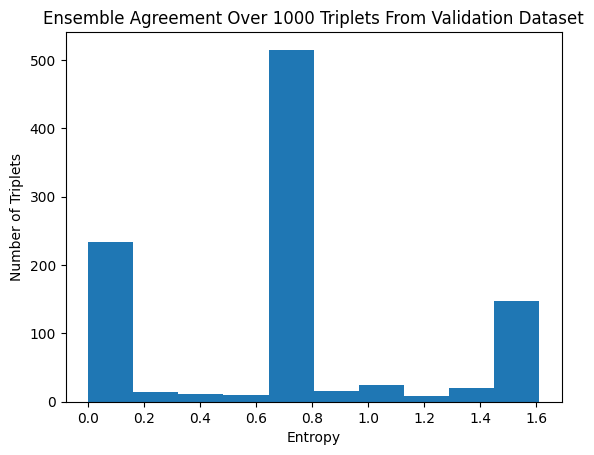

(array([233.,  14.,  12.,  10., 515.,  16.,  24.,   8.,  20., 148.]), array([0.        , 0.16094379, 0.32188758, 0.4828314 , 0.64377517,
       0.804719  , 0.9656628 , 1.1266066 , 1.2875503 , 1.4484942 ,
       1.609438  ], dtype=float32), <BarContainer object of 10 artists>)


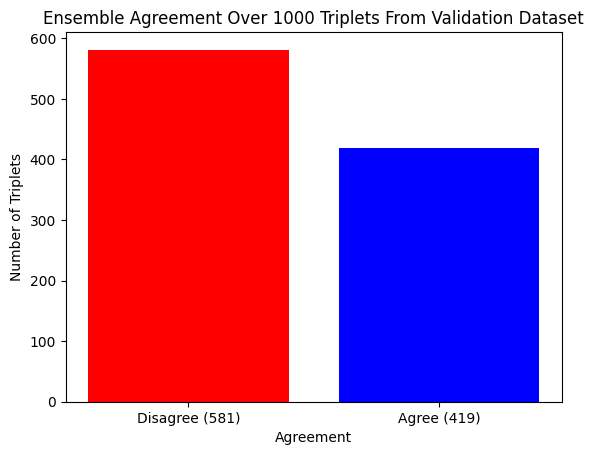

In [26]:
p = plot.hist(entropy)
plot.title("Ensemble Agreement Over 1000 Triplets From Validation Dataset")
plot.xlabel("Entropy")
plot.ylabel("Number of Triplets")
plot.show()
print(p)

plot.bar([0, 1], agreement, color=[(1, 0, 0), (0, 0, 1)])
plot.title("Ensemble Agreement Over 1000 Triplets From Validation Dataset")
plot.xlabel("Agreement")
plot.xticks([0, 1], [f"Disagree ({agreement[0]})", f"Agree ({agreement[1]})"])
plot.ylabel("Number of Triplets")
plot.show()

# Sample from Random Triplets

0.0, 2


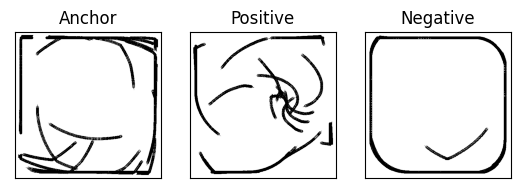

0.0, 7


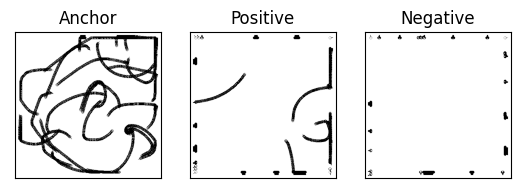

0.0, 10


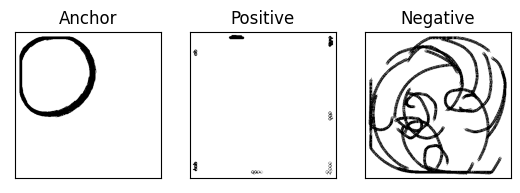

0.0, 11


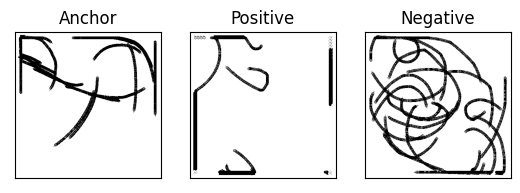

0.0, 14


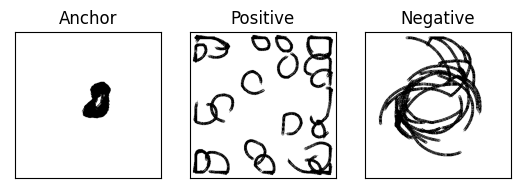

0.0, 16


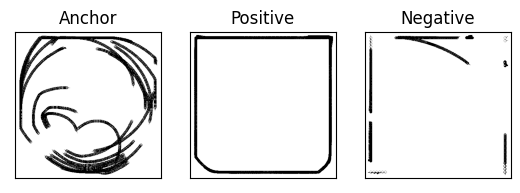

0.0, 17


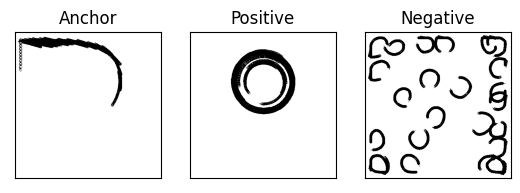

0.0, 22


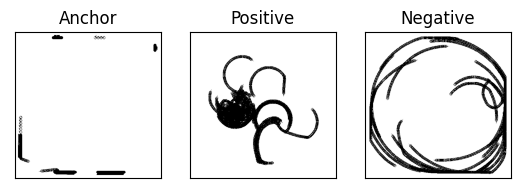

0.0, 32


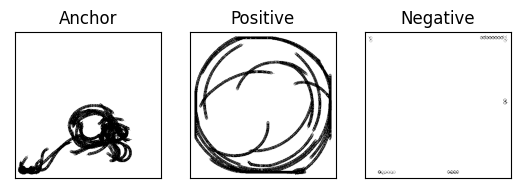

0.0, 35


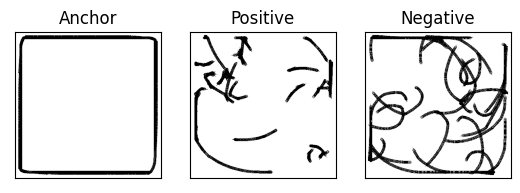

In [24]:
from scipy import ndimage
entropy_i = [(e, i) for i, e in enumerate(entropy)]
entropy_i.sort()

for j in range(10):
    e, i = entropy_i[j]
    print(f"{e}, {i}")
    fig, (ax1, ax2, ax3) = plot.subplots(1, 3)
    ax1.imshow(retrieved_data[rand_samp[i][0]][0], cmap='Greys')
    ax1.set_title("Anchor")
    ax1.set_xticks([])
    ax1.set_yticks([])
    # ax2.imshow(ndimage.rotate(retrieved_data[rand_samp[i][0]][0], 90), cmap='Greys')
    ax2.imshow(retrieved_data[rand_samp[i][1]][0], cmap='Greys')
    ax2.set_title("Positive")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.imshow(retrieved_data[rand_samp[i][2]][0], cmap='Greys')
    ax3.set_title("Negative")
    ax3.set_xticks([])
    ax3.set_yticks([])
    plot.show()

# Perform Evaluations of Medoid Accuracy

In [13]:
import os
import torch
from data.msampler import ClusterSampler
from NovelSwarmBehavior.novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from networks.ensemble import Ensemble
from matplotlib import pyplot as plot
from data.swarmset import ContinuingDataset, SwarmDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = Ensemble(size=5, output_size=5, lr=5e-4, learning_decay=0.8, decay_step=4, margin=10.0)
# ensemble.load_ensemble("surgery_ensemble")
ensemble.load_ensemble("epoch4-revised-5")
sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
parent_folder = "/home/connor/Desktop/SwarmsResults/AugmentedTests/Encoder_plus_original_bvec_Nov_7"
sub_folder = "data"
# retrieved_data = ContinuingDataset(directory=parent_folder, create=False, folder_name=sub_folder)
retrieved_data = sampled_dataset

archive = NoveltyArchive(
    pheno_file=os.path.join("/home/connor/Desktop/SwarmsResults/AugmentedTests/Encoder_plus_original_bvec_Nov_7/behaviors", "1667764573_b__1667801491.csv"),
    geno_file=os.path.join("/home/connor/Desktop/SwarmsResults/AugmentedTests/Encoder_plus_original_bvec_Nov_7/controllers", "1667764573_g__1667801491.csv"),
    absolute=True
)

archiveA = NoveltyArchive()
network = ensemble.ensemble[0]
network.eval()
for i in range(len(retrieved_data)):
    inp = torch.from_numpy(retrieved_data[i][0]).unsqueeze(0).to(device).float()
    e = network(inp).cpu().detach().numpy().squeeze(0)
    archiveA.addToArchive(e, retrieved_data[i][1])
    if i % 100 == 0:
        print(f"Transferring to Archive... {i}, {e}")

Transferring to Archive... 0, [ -659373.5   -333698.72  -446159.44 -1499706.5   1258240.2 ]
Transferring to Archive... 100, [ -659340.    -333686.84  -446132.3  -1499678.9   1258257.9 ]
Transferring to Archive... 200, [ -659380.9   -333701.34  -446164.9  -1499721.    1258249.6 ]
Transferring to Archive... 300, [ -659369.25  -333697.4   -446155.62 -1499706.    1258247.6 ]
Transferring to Archive... 400, [ -659355.6   -333693.4   -446144.06 -1499699.    1258262.4 ]
Transferring to Archive... 500, [ -659360.6   -333694.22  -446149.28 -1499695.8   1258247.2 ]
Transferring to Archive... 600, [ -659360.9   -333693.53  -446148.84 -1499695.    1258246.4 ]
Transferring to Archive... 700, [ -659366.1   -333696.4   -446152.62 -1499703.2   1258249.  ]
Transferring to Archive... 800, [ -659358.1   -333693.53  -446147.38 -1499696.6   1258250.8 ]
Transferring to Archive... 900, [ -659361.25  -333694.16  -446149.38 -1499697.    1258247.6 ]
Transferring to Archive... 1000, [ -659352.4   -333691.66  -44

In [14]:
cluster_samples = ClusterSampler(archive=archiveA, k=10)
triplets = cluster_samples.get_type_a_set()
print(triplets)

agreement = [0 for i in range(len(ensemble.ensemble) + 1)]
entropy = []
# to_query = []
for triplet in triplets:
    n = ensemble.num_networks_correct(retrieved_data[triplet[0]][0], positive=retrieved_data[triplet[1]][0], negative=retrieved_data[triplet[2]][0])
    e = ensemble.entropy_agreement(retrieved_data[triplet[0]][0], positive=retrieved_data[triplet[1]][0], negative=retrieved_data[triplet[2]][0])
    entropy.append(e)

    # if n < 2:
    #     print(f"Score {n} indexed to {len(to_query)}")
    #     to_query.append(triplet)


    print(n, e)
    agreement[n] += 1

[(4001, 431, 5918), (2689, 236, 4001), (9897, 747, 4001), (5918, 1223, 4001), (4887, 533, 8849), (8502, 530, 8849), (7517, 375, 4759), (1160, 82, 4887), (8849, 1078, 5918), (4759, 474, 5918)]
0 tensor(0.0020)
1 tensor(0.)
0 tensor(0.)
0 tensor(1.8715e-05)
1 tensor(0.)
1 tensor(0.0143)
0 tensor(0.1051)
3 tensor(9.5367e-07)
0 tensor(0.)
0 tensor(0.)


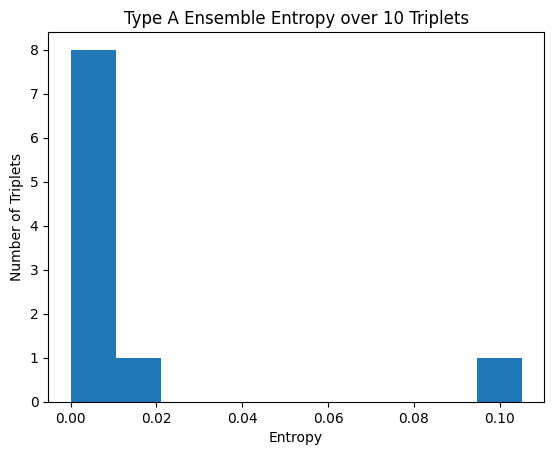

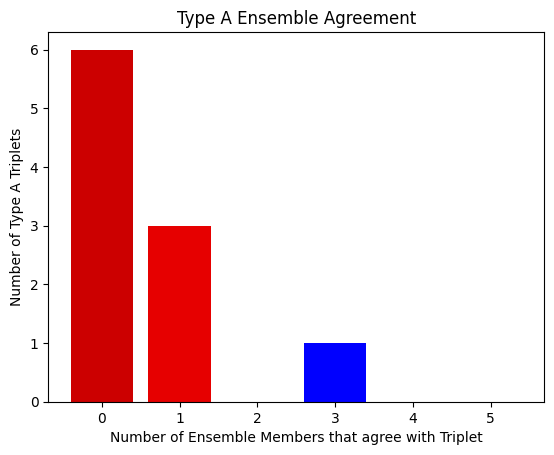

In [15]:
plot.hist(entropy)
plot.title("Type A Ensemble Entropy over 10 Triplets")
plot.xlabel("Entropy")
plot.ylabel("Number of Triplets")
plot.show()

plot.bar([i for i in range(len(ensemble.ensemble) + 1)], agreement, color=[(0.8, 0, 0), (0.9, 0, 0), (1.0, 0, 0), (0, 0, 1.0), (0, 0, 0.9), (0, 0, 0.8)])
plot.title("Type A Ensemble Agreement")
plot.xlabel("Number of Ensemble Members that agree with Triplet")
plot.xticks([i for i in range(len(ensemble.ensemble) + 1)], [i for i in range(len(ensemble.ensemble) + 1)])
plot.ylabel("Number of Type A Triplets")
plot.show()

# Retrieve Samples of High Uncertainty

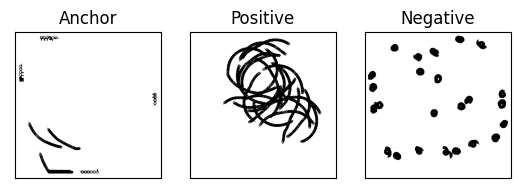

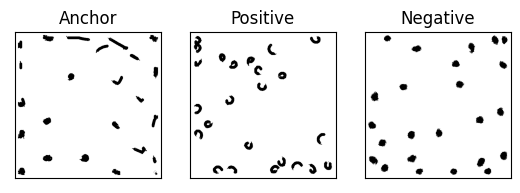

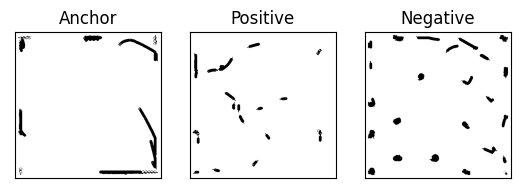

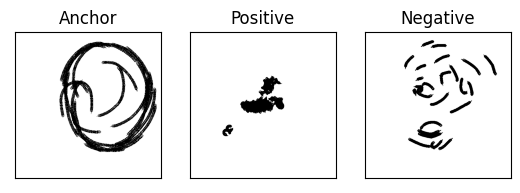

In [4]:
for triplet in to_query:
    fig, (ax1, ax2, ax3) = plot.subplots(1, 3)
    ax1.imshow(retrieved_data[triplet[0]][0], cmap='Greys')
    ax1.set_title("Anchor")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(retrieved_data[triplet[1]][0], cmap='Greys')
    ax2.set_title("Positive")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.imshow(retrieved_data[triplet[2]][0], cmap='Greys')
    ax3.set_title("Negative")
    ax3.set_xticks([])
    ax3.set_yticks([])
    plot.show()

# Test HIL Triplets

In [8]:
# HIL Triplets provided from the user
triplet_classes = [
    [(0, 0), (0, 1), (2, 0), (2, 1), (3, 2)],
    [(0, 2), (1, 0), (1, 1), (1, 2), (2, 2)],
    [(3, 0)],
    [(3, 1)]
]

permute_triplets = []
rotate_triplets = []

for i in range(len(triplet_classes)):
    for j in range(len(triplet_classes[i])):
        anchor = triplet_classes[i][j]
        for k in range(j + 1, len(triplet_classes[i])):
            positive = triplet_classes[i][k]
            for l in range(i + 1, len(triplet_classes)):
                for m in range(len(triplet_classes[l])):
                    negative = triplet_classes[l][m]
                    permute_triplets.append((anchor, positive, negative))

for i in range(len(triplet_classes)):
    for j in range(len(triplet_classes[i])):
        anchor = triplet_classes[i][j]
        for l in range(i + 1, len(triplet_classes)):
            for m in range(len(triplet_classes[l])):
                negative = triplet_classes[l][m]
                rotate_triplets.append((anchor, negative))

sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
ensemble = Ensemble(size=5, output_size=5, lr=5e-4, learning_decay=0.9, decay_step=3)
ensemble.load_ensemble("epoch4-revised-4")
ensemble.training_mode()

TARGET = 0.08
average_loss = 1000
epoch = 0
# Training
while average_loss > TARGET:
    losses = [0.0 for _ in range(len(ensemble.ensemble))]
    total = 0

    for anchor, positive, negative in permute_triplets:
        a, p, n = to_query[anchor[0]][anchor[1]], to_query[positive[0]][positive[1]], to_query[negative[0]][negative[1]]
        loss = train(ensemble, sampled_dataset[a][0], sampled_dataset[p][0], sampled_dataset[n][0])
        losses += loss
        total += 1
        if total % 20 == 0:
            print(f"Permute Progress... {total}")

    print("Permuation Triplets Complete")

    for anchor, negative in rotate_triplets:
        a, n = to_query[anchor[0]][anchor[1]], to_query[negative[0]][negative[1]]
        loss = train(ensemble, sampled_dataset[a][0], sampled_dataset[a][0], sampled_dataset[n][0])
        losses += loss
        total += 1
        if total % 20 == 0:
            print(f"Rotation Progress... {total}")

    average_loss = sum(losses / total) / len(losses)

    print("Rotation Triplets Complete")
    print(f"Epoch: {epoch}, average loss: {average_loss}, losses: {losses / total}")

    if epoch % 20 == 0:
        losses = pretraining(sampled_dataset, ensemble, data_cutoff=None, data_size=500)
        average_loss += (sum(losses) / len(losses))
        print(f"Average: {(sum(losses) / len(losses))}, Pretraining Loss: {losses}")
        print(f"Combined Average Loss: {average_loss}")

    ensemble.step_schedulers()
    epoch += 1

Permute Progress... 20
Permute Progress... 40
Permute Progress... 60
Permute Progress... 80
Permuation Triplets Complete
Rotation Progress... 100
Rotation Progress... 120
Rotation Triplets Complete
Epoch: 0, average loss: 1.6345147086416976, losses: [0.27404512 4.38827633 0.54304402 2.75058293 0.21662514]
Unsupervised Training.. 0.0


/tmp/ipykernel_2394247/915310130.py:108: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 5.0
Unsupervised Training.. 10.0
Unsupervised Training.. 15.0
Unsupervised Training.. 20.0
Unsupervised Training.. 25.0
Unsupervised Training.. 30.0
Unsupervised Training.. 35.0
Unsupervised Training.. 40.0
Unsupervised Training.. 45.0
Unsupervised Training.. 50.0
Unsupervised Training.. 55.0
Unsupervised Training.. 60.0
Unsupervised Training.. 65.0
Unsupervised Training.. 70.0
Unsupervised Training.. 75.0
Unsupervised Training.. 80.0
Unsupervised Training.. 85.0
Unsupervised Training.. 90.0
Unsupervised Training.. 95.0
Average: 2.16549396058768, Pretraining Loss: [1.7940115  3.02352214 2.52229647 1.96356466 1.52407503]
Combined Average Loss: 3.8000086692293777
Permute Progress... 20
Permute Progress... 40
Permute Progress... 60
Permute Progress... 80
Permuation Triplets Complete
Rotation Progress... 100
Rotation Progress... 120
Rotation Triplets Complete
Epoch: 1, average loss: 71.92966420794565, losses: [ 15.41115752   9.72113153 295.37225838  19.83951509  19.

In [9]:
ensemble.save_ensemble("epoch4-revised-5")

# Training with HIL

In [ ]:
import torch
from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from hil.HIL import HIL
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter
from networks.ensemble import Ensemble

trial_name = f"{str(int(time.time()))}"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = Ensemble(size=5)

TRAIN = True
SAVE_CLUSTER_IMAGES = True
SAVE_CLUSTER_MEDOIDS = True
PRETRAINING = True
HUMAN_IN_LOOP = True
SYNTHETIC_HIL = False
EVOLUTION = True
CLUSTER_AND_DISPLAY = True
CONCAT_BVEC_AND_EVEC = True
PASS_THROUGHS = 1
RESULTS_DATA_SIZE = 10000
EVOLUTIONS_PER_EPOCH = 50
K_CLUSTERS = 8
INITIAL_EVOLVES = 3

anchor_dataset = ContinuingDataset("data")
sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
evolution, _ = evolution_controller()

hil = HIL(name=trial_name, synthetic=SYNTHETIC_HIL, data_limiter=RESULTS_DATA_SIZE, clusters=K_CLUSTERS)
HIL_archive = DataAggregationArchive()
random_archive = DataAggregationArchive(scalar=True)
EPSILON = 0.5

simulation_time = 0
evolution_time = 0
training_time = 0
hil_time = 0


# TODO: Add Randomly-sampled Contrastive/Triplet Loss
if PRETRAINING:
    ensemble.load_model("two_sensor_subz1")
    print("Pretrained model loaded!")

dataset = anchor_dataset if EVOLUTION else sampled_dataset

if TRAIN:
    writer = SummaryWriter()
    STOP_FLAG = False
    for epoch in range(PASS_THROUGHS + 1):
        if EVOLUTION:
            start_time = time.time()
            evolution.restart_screen()
            for gen in range(EVOLUTIONS_PER_EPOCH if epoch > 0 else INITIAL_EVOLVES):
                # Simulate current population + Save Data
                for i in range(len(evolution.getPopulation())):
                    # The collection of the original behavior vector below is only used to collect data to compare with the baseline
                    visual_behavior, genome, baseline_behavior = evolution.next()
                    dataset.new_entry(visual_behavior, genome, baseline_behavior)
                simulation_time += (time.time() - start_time)

                # Then, evolve
                start_time = time.time()

                # PARENT NETWORK?
                embedded_archive = hil.getEmbeddedArchive(dataset, ensemble[0], concat_behavior=CONCAT_BVEC_AND_EVEC)
                evolution.overwriteArchive(embedded_archive, random_archive)
                embedded_behavior = embedded_archive.archive[-evolution.evolve_config.population:]
                evolution.overwriteBehavior(embedded_behavior)
                evolution.evolve()
                evolution.restart_screen()
                evolution_time += (time.time() - start_time)

                print(f"Evolution complete for e{epoch} and gen{gen}")
                print(f"Size of Evolved Archive: {len(evolution.behavior_discovery.archive.archive)}")

                # Record the accuracy of the medoids with respect to the synthetic policy
                medoid_acc, cluster_acc = 0, 0
                if len(dataset) > 0 and SAVE_CLUSTER_MEDOIDS:
                    if SYNTHETIC_HIL and EVOLUTION:
                        hil.synthetic_knowledge = hil.syntheticBehaviorSpace(dataset)
                        print(f"Synthetic Human Knowledge Size: {len(hil.synthetic_knowledge.labels_)}")
                    medoid_acc, cluster_acc = hil.record_medoids(ensemble[0], dataset)

                # Cluster current dataset, display clusters, and save for analysis
                if len(dataset) > 0 and SAVE_CLUSTER_IMAGES:
                    hil.embed_and_cluster(ensemble[0], dataset, auto_quit=True)
                    evolution.restart_screen()

                evolution.saveArchive(trial_name)

        # Human in the Loop determines behavior embedding
        if HUMAN_IN_LOOP and epoch < PASS_THROUGHS:
            start_time = time.time()
            improvements, human_loss, triplet_helpfulness, _ =   human_in_the_loop(
                                                                dataset,
                                                                ensemble[0],
                                                                optimizer,
                                                                loss_fn,
                                                                HIL_archive,
                                                                random_archive,
                                                                len(dataset)
                                                            )
            hil_time += (time.time() - start_time)

        # Train on past user information
        if TRAIN:
            start_time = time.time()
            losses = None

            average_loss = 50
            loop = 0
            BATCH_SIZE = 5
            ensemble.training_mode()
            while (average_loss > 0.01) and loop < 20:
                loss_sum = 0
                total_loss = 0
                for i, (anchor, pos, neg) in enumerate(HIL_archive):
                    anchor_encoding = dataset[anchor][0]
                    similar_encoding = dataset[pos][0]
                    anti_encoding = dataset[neg][0]
                    losses = ensemble.train_triplet(anchor_encoding, similar_encoding, anti_encoding)
                    total_loss += len(losses)
                    loss_sum += sum(losses)

                    if losses is not None and i > 0 and i % 20 == 0:
                        print(f"Epoch Progress: {(i*100) / len(HIL_archive)}%, Immediate Loss: {sum(losses) / len(losses)}")

                average_loss = loss_sum / (total_loss + 1)
                print(f"Loop: {loop}, Average Loss: {average_loss}")
                loop += 1

            print(f"Epoch: {epoch}")
            training_time += (time.time() - start_time)

            writer.add_scalar("Loss/Average", loss_sum / (total_loss + 1), epoch)

        if SAVE_CLUSTER_MEDOIDS:
            writer.add_scalar("Accuracy/MedoidClassification", medoid_acc, epoch)
            writer.add_scalar("Accuracy/RandomSampleClassification", cluster_acc, epoch)

        if HUMAN_IN_LOOP:
            writer.add_scalar("Loss/TripletQuality", triplet_helpfulness, epoch)
            writer.add_scalar("Queries/Total_Human_Queries", epoch*8*9, epoch)
            writer.add_scalar("Queries/Total_Triplets_Generated", len(HIL_archive), epoch)
            writer.add_scalar("Queries/Total_Random_Classes", len(random_archive), epoch)

        if EVOLUTION:
            writer.add_scalar("Novelty/Highest", evolution.behavior_discovery.getBestScore(), epoch)
            writer.add_scalar("Novelty/Average", evolution.behavior_discovery.getAverageScore(), epoch)

        writer.add_scalar("Time/Simulation", simulation_time, epoch)
        writer.add_scalar("Time/HIL", hil_time, epoch)
        writer.add_scalar("Time/Evolution", evolution_time, epoch)
        writer.add_scalar("Time/Training", training_time, epoch)

evolution.close()

In [ ]:
# Evolve and Display?
print(len(evolution.archive.archive))

In [ ]:
import pygame
pygame.quit()

# Pretraining

/home/connor/Desktop/research/SwarmNoveltyNetwork/networks/ensemble.py:10: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  torch.nn.init.uniform(m.weight)


NameError: name 'np' is not defined

In [ ]:
import torch
from networks.embedding import NoveltyEmbedding
from NovelSwarmBehavior.novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from NovelSwarmBehavior.novel_swarms.config.ResultsConfig import ResultsConfig
from NovelSwarmBehavior.novel_swarms.config.defaults import ConfigurationDefaults
from data.swarmset import DataBuilder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = NoveltyEmbedding().to(device)
network.load_model("trialA-10-18-2022")
# anchor_dataset = SwarmDataset("data/full", rank=0)

WRITE_OUT = True
if WRITE_OUT:
    network.eval()
    test_archive = NoveltyArchive()
    for i in range(len(anchor_dataset)):
        anchor_encoding, genome, _ = anchor_dataset[i]
        anchor_encoding = torch.from_numpy(anchor_encoding).to(device).float()
        embedding = network(anchor_encoding.unsqueeze(0)).squeeze(0).cpu().detach().numpy()
        test_archive.addToArchive(embedding, genome)

In [ ]:
from ui.clustering_gui import ClusteringGUI
import pygame

agent_config = ConfigurationDefaults.DIFF_DRIVE_AGENT
world_config = ConfigurationDefaults.RECTANGULAR_WORLD
world_config.addAgentConfig(agent_config)
config = ResultsConfig(archive=test_archive, k_clusters=6, world_config=world_config, tsne_perplexity=16, tsne_early_exaggeration=12, skip_tsne=False)
gui = ClusteringGUI(config)
gui.displayGUI()
# results(config)
pygame.quit()

# Clustering + Analysis

In [ ]:
from ui.clustering_gui import ClusteringGUI

# Cluster over saved behaviors
archive = NoveltyArchive()
for i, (_, genome, behavior, _, _, _, _) in enumerate(anchor_dataset):
    archive.addToArchive(vec=behavior, genome=genome)

agent_config = ConfigurationDefaults.DIFF_DRIVE_AGENT
world_config = ConfigurationDefaults.RECTANGULAR_WORLD
world_config.addAgentConfig(agent_config)
config = ResultsConfig(archive=archive, k_clusters=7, world_config=world_config, tsne_perplexity=20, tsne_early_exaggeration=2, skip_tsne=False)

gui = ClusteringGUI(config)
gui.displayGUI()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(human_l_hist, "b", label='Human Loss')
plt.ylabel("Loss")
plt.xlabel("Time (Epochs)")
plt.legend()